# Ridge Regression Pipeline

In [292]:
# Librerías de manipulación de tablas, datos y fórmulas
import numpy as np
import pandas as pd
# Librerías de Machine Learning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn import preprocessing
# Librería para guardar el modelo
import joblib
# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [293]:
df_casas4 = pd.read_excel('casas_idealista_analisis.xlsx')

In [294]:
df_casas4.head()

,titulo,localizacion,precio,metros_cuadrados,habitaciones,baños,ascensor,año,trastero,orientacion,metros_reales,condicion,armarios_empotrados,terraza,balcon,jardin,garaje,calefaccion,aire_acondicionado,altura_piso
0,Piso en venta en calle de Fra Juníper Serra,Vara de Quart,210000,118,4,2,1,1977,0,oeste,118,Segunda mano/buen estado,0,0,1,0,0,1,1,PISOS ALTOS
1,"Piso en venta en avenida Pérez Galdós, 33",Patraix,336500,141,3,2,1,2023,0,Desconocida,141,Promoción de obra nueva,0,1,0,0,0,0,0,PISOS BAJOS
2,"Piso en venta en avenida Pérez Galdós, 33",Patraix,341500,141,3,2,1,2023,0,Desconocida,141,Promoción de obra nueva,0,1,0,0,0,0,0,PISOS BAJOS
3,Ático en venta en calle josep melia y castello,Sant Isidre,150000,66,1,1,1,0,0,Desconocida,66,Segunda mano/buen estado,0,1,0,0,0,1,1,PISOS ALTOS
4,"Piso en venta en avenida Pérez Galdós, 33",Patraix,356500,150,3,2,1,2023,0,Desconocida,150,Promoción de obra nueva,0,1,0,0,0,0,0,PISOS BAJOS


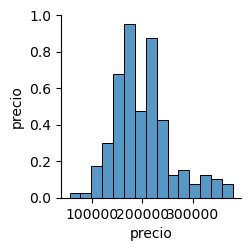

In [295]:
# Veo la dispersión de los datos de precio
sns.pairplot(df_casas4[['precio']])

#### Se puede observar que hay valores extremos que nos pueden trastocar nuestro algoritmo lineal. Para evitarlo vamos a aplicar una transformación de un logaritmo en base 10.

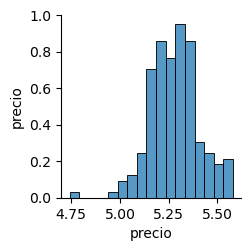

In [296]:
sns.pairplot(np.log10(df_casas4[['precio']]))

#### Ahora sí que podemos ver los datos mas juntos y no tan dispersados

In [297]:
df_casas4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   titulo               183 non-null    object
 1   localizacion         183 non-null    object
 2   precio               183 non-null    int64 
 3   metros_cuadrados     183 non-null    int64 
 4   habitaciones         183 non-null    int64 
 5   baños                183 non-null    int64 
 6   ascensor             183 non-null    int64 
 7   año                  183 non-null    int64 
 8   trastero             183 non-null    int64 
 9   orientacion          183 non-null    object
 10  metros_reales        183 non-null    int64 
 11  condicion            183 non-null    object
 12  armarios_empotrados  183 non-null    int64 
 13  terraza              183 non-null    int64 
 14  balcon               183 non-null    int64 
 15  jardin               183 non-null    int64 
 16  garaje  

In [298]:
# Voy a separar la Y, que va a ser la variable de los precios a predecir, y la X, que van a ser todas las variables que no sean
# string (titulo), menos el precio que es la variable Y
x, y = df_casas4.drop(['precio','titulo'], axis=1), df_casas4['precio']

In [299]:
from sklearn.model_selection import train_test_split
# Divido el conjunto de datos en dos grupos, uno de entrenamiento y otro de test
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [300]:
from sklearn.preprocessing import OneHotEncoder
# Especifico las columnas categóricas y las numéricas
categorical_columns = ['localizacion','orientacion','condicion','altura_piso']
numerical_columns = ['metros_cuadrados', 'habitaciones', 'baños', 'ascensor', 'año', 
                     'trastero', 'metros_reales', 'armarios_empotrados', 'terraza', 'balcon', 
                     'jardin', 'garaje', 'calefaccion', 'aire_acondicionado']
# Creo preprocesador, donde las variables categóricas se conviertan en numéricas
preprocessor = make_column_transformer((OneHotEncoder(drop='if_binary'), categorical_columns), remainder = 'passthrough',
                                       verbose_feature_names_out = False,)

In [301]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
import scipy as sp
# Creo pipeline donde aplico a los datos el preprocesador, y la regresion Ridge aplicando el logaritmo en base 10
model = make_pipeline(preprocessor, TransformedTargetRegressor(regressor=Ridge(alpha=1e-10),
                                                               func=np.log10,inverse_func=sp.special.exp10),)

In [302]:
# Entreno el modelo
model.fit(X_train, y_train)

C:\Users\danal\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.10068e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['localizacion',
                                                   'orientacion', 'condicion',
                                                   'altura_piso'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [303]:
from sklearn.metrics import median_absolute_error

# Aplico predicciones sobre los datos de entrenamiento
y_pred = model.predict(X_train)
# MAE de las predicciones en los datos de entrenamiento
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE en conjunto entrenamiento: {mae:.2f} euros'
# Aplico predicciones sobre los datos de test
y_pred = model.predict(X_test)
# MAE de las predicciones en los datos de test
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE en conjunto test: {mae:.2f} euros'

Text(0.5, 0, 'Valores reales')

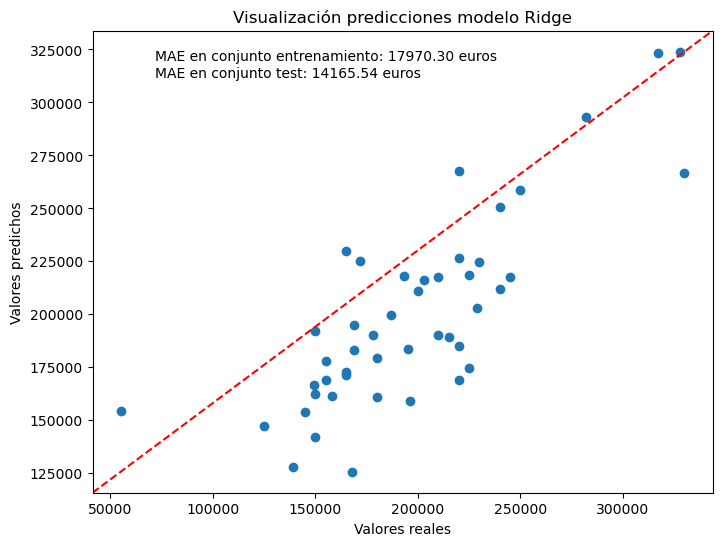

In [304]:
# Creo gráfica de las predicciones sobre los datos reales
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform = ax.transAxes, ls = '--', c='red')
plt.text(0.1, 0.9, string_score, transform=ax.transAxes)
plt.title('Visualización predicciones modelo Ridge')
plt.ylabel('Valores predichos')
plt.xlabel('Valores reales')

#### A continuación vamos a ver cuanto peso nos aporta en el modelo, cada variable por separado.

In [305]:
# Obtengo los nombres de las variables del modelo
feature_names = model[:-1].get_feature_names_out()
# Creo dataframe en el que extraigo los coeficientes de cada variable, y los asigno a una nueva columna llamada 'Coeficientes'
coefs = pd.DataFrame(model[-1].regressor_.coef_, columns = ['Coeficientes'], index = feature_names,)
coefs

,Coeficientes
localizacion_Barrio de Favara,0.043591
localizacion_Patraix,0.009861
localizacion_Safranar,0.048511
localizacion_Sant Isidre,-0.082707
localizacion_Vara de Quart,-0.019268
orientacion_Desconocida,-0.021002
orientacion_este,0.002655
orientacion_norte,-0.002618
orientacion_oeste,0.026537
orientacion_sur,-0.005588


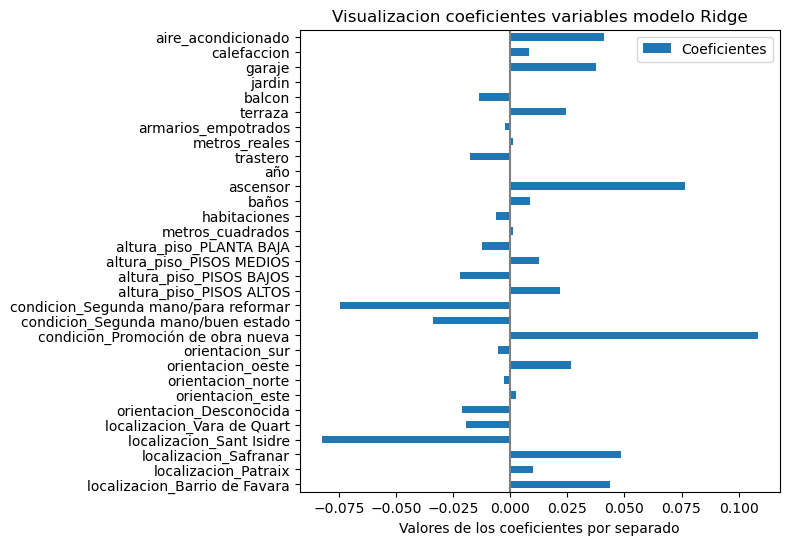

In [306]:
# Creo gráfica para verlo mejor
coefs.plot.barh(figsize=(8, 6))
plt.title('Visualización coeficientes variables modelo Ridge')
plt.axvline(x=0, color='.5')
plt.xlabel('Valores de los coeficientes por separado')
plt.subplots_adjust(left=0.3)

#### Ahora ya podemos tener una mejor idea de qué variables tienen más peso sobre el ajuste del modelo. De todas formas en este gráfico no se visualiza del todo bien puesto que los valores no están todos en la misma escala. Vamos a escalarlos correctamente!

In [307]:
# Creo un dataframe para almacenar la varianza de cada variable
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names)
X_train_preprocessed.std(axis=0)

localizacion_Barrio de Favara             0.235348
localizacion_Patraix                      0.495904
localizacion_Safranar                     0.375134
localizacion_Sant Isidre                  0.235348
localizacion_Vara de Quart                0.346887
orientacion_Desconocida                   0.494712
orientacion_este                          0.330891
orientacion_norte                         0.313398
orientacion_oeste                         0.304009
orientacion_sur                           0.272742
condicion_Promoción de obra nueva         0.322346
condicion_Segunda mano/buen estado        0.424659
condicion_Segunda mano/para reformar      0.322346
altura_piso_PISOS ALTOS                   0.346887
altura_piso_PISOS BAJOS                   0.497956
altura_piso_PISOS MEDIOS                  0.483187
altura_piso_PLANTA BAJA                   0.235348
metros_cuadrados                         25.748782
habitaciones                              0.983440
baños                          

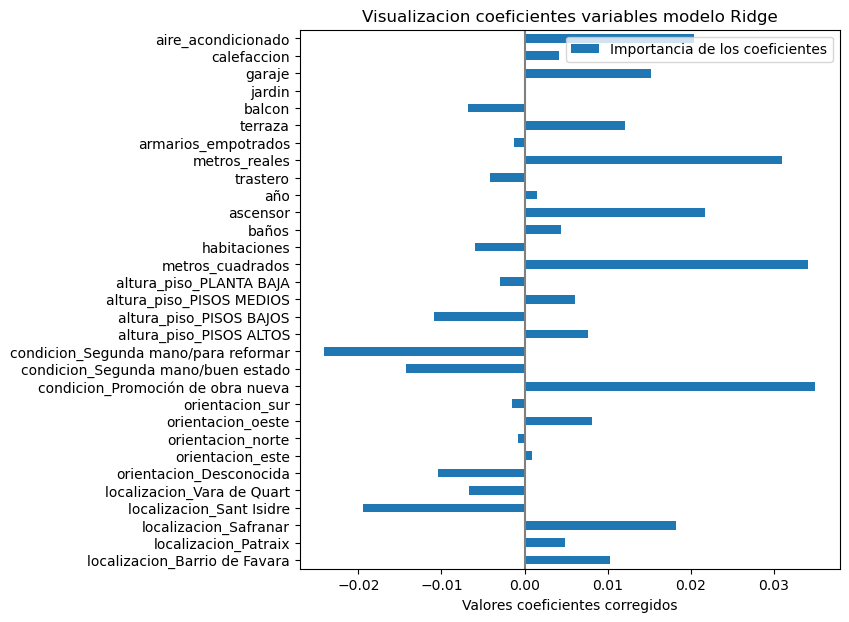

In [308]:
# Cojo el dataframe de los coeficientes del modelo, y a cada variable le multiplico la varianza que hemos sacado 
# en el dataframe anterior 'X_train_preprocessed'
coefs= pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns = ['Importancia de los coeficientes'],
    index=feature_names,)
# Creo gráfico de barras
coefs.plot(kind='barh', figsize = (9, 7))
plt.xlabel('Valores coeficientes corregidos')
plt.title('Visualización coeficientes variables modelo Ridge')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left = 0.3)

#### Ahora sí que podemos visualizar mejor el peso real de cada variable, sobre las predicciones del modelo.

In [309]:
# Voy a hacer una validación cruzada con los datos, para asegurarme de que el modelo funciona bien en la predicción de todos 
# los pisos
from sklearn.model_selection import cross_validate, RepeatedKFold
# Creo objeto Kfold para que me divida los datos en 5 partes y repita las predicciones 5 veces
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
# Creo modelo de validación cruzada regularizada, que contiene el modelo entrenado anteriormente, los datos que tenemos x/y 
# a splitear, y el objeto Kfold
cv_model = cross_validate(model, x, y, cv=cv, return_estimator=True, n_jobs=2,)
# Saco los coeficientes teniendo en cuenta la varianza o desviación estandar.
coefs = pd.DataFrame([est[-1].regressor_.coef_ * est[:-1].transform(x.iloc[train_idx]).std(axis=0)
                      # Itero los índices de la validación cruzada, para ir almacenando los resultados estimados, 
                      # troceados por el objeto Kfold con los datos de x/y
                      for est, (train_idx, _) in zip(cv_model['estimator'], cv.split(x, y))], columns=feature_names,)

Text(0.5, 1.0, 'Importancia de los coeficientes y su variabilidad')

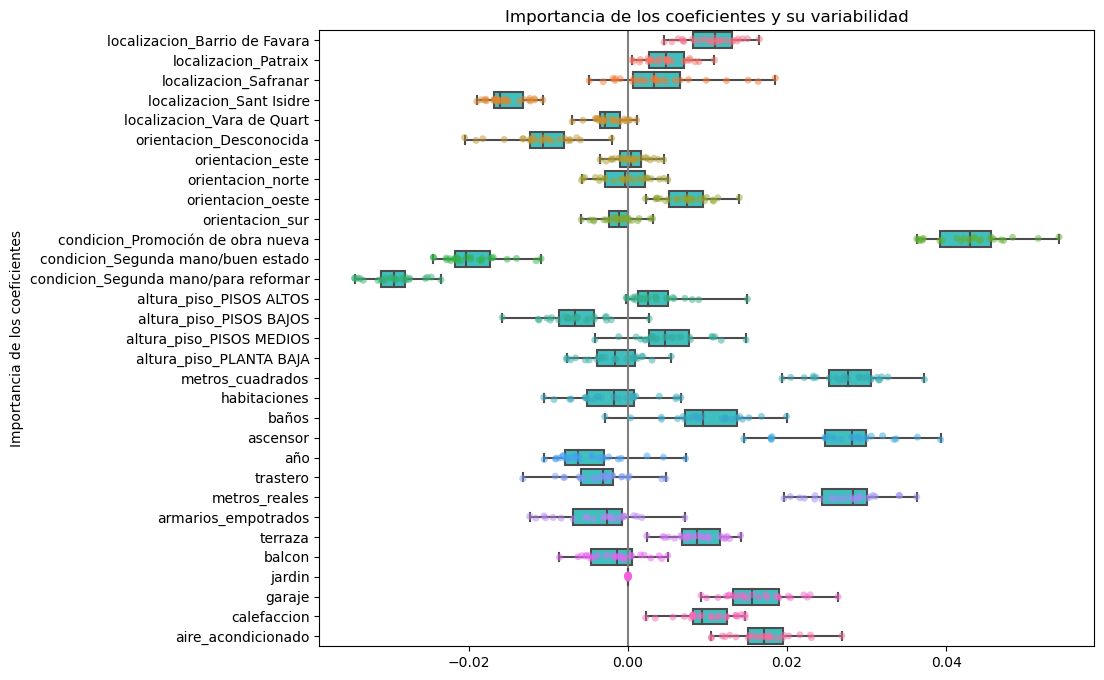

In [310]:
# Creo gráfico de cajas
plt.figure(figsize=(10,8))
sns.stripplot(data=coefs, orient='h', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5, whis=10)
plt.axvline(x=0, color='.5')
plt.ylabel('Importancia de los coeficientes')
plt.title('Importancia de los coeficientes y su variabilidad')


#### Aqui podríamos observar si hay variables que sus varianzas están afectando de manera negativa al modelo, y así estar a tiempo de eliminarlas, para volver a realizar la validación cruzada y obtener mejores resultados. En nuestro caso la varianza de todas las variables es normal por lo que procedemos a continuar con el proyecto.

In [311]:
from sklearn.linear_model import RidgeCV
# Voy a entrenar el modelo para sacar el mejor alpha a aplicar en el algoritmo
# Indico un rango de alphas a comparar
alphas = np.logspace(-10, 10, 21)
# Creo pipeline donde aplico a los datos, el preprocesador, y en este caso, la regresión RidgeCV que se ejecuta varias veces 
# hasta encontrar el mejor alpha, y luego le aplico el logaritmo en base 10
model = make_pipeline(preprocessor, TransformedTargetRegressor(regressor=RidgeCV(alphas=alphas),
                                                               func=np.log10,inverse_func=sp.special.exp10),)
# Entreno el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['localizacion',
                                                   'orientacion', 'condicion',
                                                   'altura_piso'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

In [312]:
# Saco el mejor alpha
model[-1].regressor_.alpha_

10.0

### Predicción final

In [313]:
# Aplico predicciones sobre los datos de entrenamiento
y_pred = model.predict(X_train)
# MAE de las predicciones en los datos de entrenamiento
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE en conjunto entrenamiento: {mae:.2f} €'
# Aplico predicciones sobre los datos de test
y_pred = model.predict(X_test)
# MAE de las predicciones en los datos de test
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE en conjunto test: {mae:.2f} €'
# Saco el R^2
r2_test = r2_score(y_test, y_pred)
string_score += f'\nR^2 en conjunto test: {r2_test:.2f}'

Text(0.5, 0, 'Valores Reales')

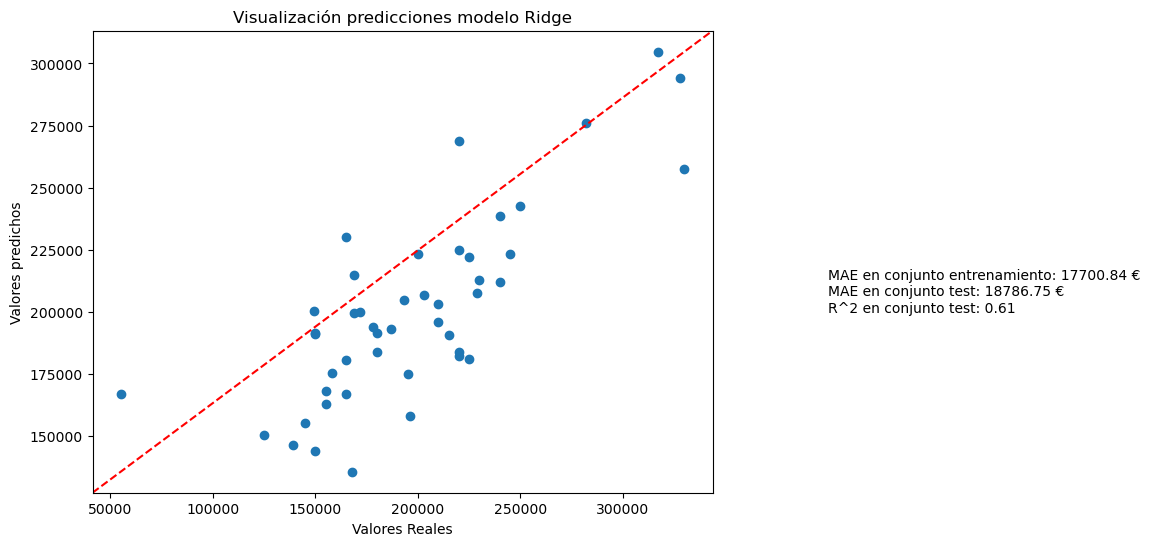

In [314]:
# Creo gráfico para la visualización de las predicciones y sus coeficientes
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform = ax.transAxes, ls = '--', c='red')
plt.text(400000, 200000, string_score)
plt.title('Visualización predicciones modelo Ridge')
plt.ylabel('Valores predichos')
plt.xlabel('Valores Reales')

### Llegamos a la conclusión de que despues de haberle aplicado una transformación logarítmica a los datos, y haber vuelto a extraer el mejor alpha en una validación cruzada para la predicción del algoritmo, nos ha reducido el margen de error (MAE), desde unos 28 mil que teníamos al principio, a unos 18 mil. Lo cual está muy bien!!!

In [315]:
# Creo dataframe de las predicciones
df_preds = pd.DataFrame({'Predicciones': y_pred})
# Redondeo los valores de 'predicciones' para eliminar los decimales
df_preds['Predicciones'] = df_preds['Predicciones'].round(0)

In [320]:
# Creo índice nuevo para el dataframe
df_casas_pred = df_casas4.reset_index(drop = True, inplace = True)
# Creo nuevo dataframe y elimino las columnas que no me interesan para el dataframe de la comparativa de las predicciones
df_casas_pred = df_casas4.copy()
df_casas_pred = df_casas_pred.drop(columns = ['orientacion', 'ascensor', 'baños', 'trastero', 'altura_piso',
                                              'habitaciones', 'metros_reales', 'condicion', 'armarios_empotrados', 'terraza', 
                                              'balcon', 'jardin', 'garaje', 'calefaccion', 'aire_acondicionado'])

In [323]:
# Uno los dos dataframes en uno
df_casas_pred_finales = df_casas_pred.merge(df_preds, left_index=True, right_index=True, how='inner')
df_casas_pred_finales.head()

,titulo,localizacion,precio,metros_cuadrados,año,Predicciones
0,Piso en venta en calle de Fra Juníper Serra,Vara de Quart,210000,118,1977,146380.0
1,"Piso en venta en avenida Pérez Galdós, 33",Patraix,336500,141,2023,203381.0
2,"Piso en venta en avenida Pérez Galdós, 33",Patraix,341500,141,2023,181186.0
3,Ático en venta en calle josep melia y castello,Sant Isidre,150000,66,0,190936.0
4,"Piso en venta en avenida Pérez Galdós, 33",Patraix,356500,150,2023,206674.0


In [325]:
# Configuro Pandas para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Convierto el DataFrame a una cadena y muestra todas las filas
print(df_casas_pred_finales.to_string(index=False))

                                                  titulo     localizacion  precio  metros_cuadrados  año  Predicciones
             Piso en venta en calle de Fra Juníper Serra    Vara de Quart  210000               118 1977      146380.0
               Piso en venta en avenida Pérez Galdós, 33          Patraix  336500               141 2023      203381.0
               Piso en venta en avenida Pérez Galdós, 33          Patraix  341500               141 2023      181186.0
          Ático en venta en calle josep melia y castello      Sant Isidre  150000                66    0      190936.0
               Piso en venta en avenida Pérez Galdós, 33          Patraix  356500               150 2023      206674.0
                Piso en venta en calle Archiduque Carlos         Safranar  179000                56 1996      175522.0
                          Piso en venta en calle d'Aiora          Patraix  285000               135 1972      268855.0
          Ático en venta en calle josep melia y 

In [326]:
# Me quedo solo con las casas cuyo precio está por debajo de la predicción, pues eso quiere decir que tienen precios
# más económicos en relación a su valor real.
df_casas_pred_finales[df_casas_pred_finales.precio<df_casas_pred_finales.Predicciones]

,titulo,localizacion,precio,metros_cuadrados,año,Predicciones
3,Ático en venta en calle josep melia y castello,Sant Isidre,150000,66,0,190936.0
7,Ático en venta en calle josep melia y castello,Sant Isidre,150000,66,0,204952.0
8,Piso en venta en calle Pío XI,Safranar,169000,100,1971,222030.0
9,Ático en venta en Sant Isidre,Patraix,150000,100,2008,238783.0
10,"Piso en venta en calle de Campos Crespo, 5",Barrio de Favara,209000,122,2009,214991.0
13,Ático en venta en Primitiu Gómez serrano,Sant Isidre,149900,90,2008,174949.0
15,Piso en venta en calle Virgen de la Cabeza,Vara de Quart,158000,96,1974,224979.0
18,Piso en venta en calle de l'Arxiduc Carles,Safranar,229000,107,1976,304728.0
19,Piso en venta en Patraix,Patraix,139000,102,1966,193968.0
20,"Piso en venta en Gaspar Aguilar, 16",Patraix,193000,105,0,199658.0


In [328]:
# Guardo el modelo en joblib
joblib.dump(model, 'ridge_model_idealista.pkl')

['ridge_model_idealista.pkl']

In [319]:
# Exporto el DataFrame a un archivo Excel
df_casas_pred_finales.to_excel('casas_idealista_pred_finales.xlsx', index=False)
# Y a CSV
df_casas_pred_finales.to_csv('casas_idealista_pred_finales.csv', index=False, sep=';', encoding='utf-16')